# Access Database-Files to explore and summerise Data

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [2]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [3]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2014-10-07/data_eval_new/"
file_name = "int_norm_20141007_no_bgd.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [4]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [5]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [6]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/no_bgd_corr/df_bgd_corr',
 '/evaluation/no_bgd_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/no_bgd_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/no_bgd_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/no_bgd_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/no_bgd_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/no_bgd_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/no_bgd_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/no_bgd_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/no_bgd_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/no_bgd_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/no_bgd_corr/r_118_120/No_interference_corr/df_internal_norm',
 '/evaluation/n

# Plot raw data and check measurement

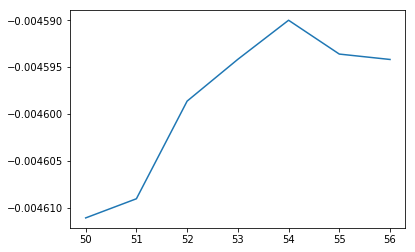

In [7]:
# Check Baselines
column = "116"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

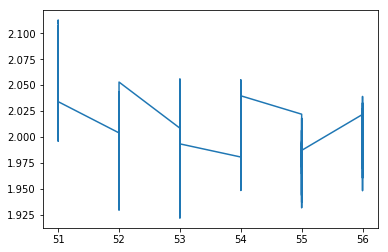

In [9]:
# Check Signals
column = "122"
sample = "SPEX1 100ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

In [10]:
df_mean(signals[signals["118"] < 0.05])

,Filenumber,Sample,110,111,112,113,114,115,116,117,...,120_2,121_2,122_2,123_2,124_2,125_2,126_2,127_2,129_2,131_2
Date,,,,,,,,,,,,,,,,,,,,,
2014-10-07 22:55:00,50,wash clean,0.001777,0.001852,0.003574,0.001781,0.004249,0.000047,0.002868,0.000857,...,0.004057,0.000008,0.000635,0.000042,0.00089,0.000282,0.000822,0.073729,0.012633,0.010392


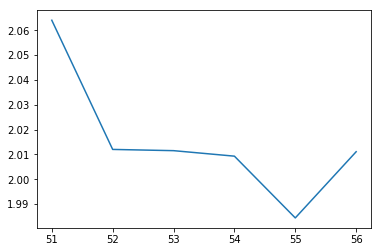

In [11]:
# Check Signals - mean
column = "122"
sample = "SPEX1 100ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

In [12]:
# Check background 
column = "118"
sample = "SPEX1 100ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

KeyError: 'No object named /evaluation/bgd_outlier_corr/df_bgd_corr in the file'

In [213]:
background_mean = df_mean(background)

# Outlier rejection

In [77]:
bgd_method = 'no_bgd_corr' #'no_bgd_corr'
norm_ratio = "r_118_120"
interf_corr = "Te125_Xe129_corr"

In [78]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [79]:
column = "124/120"
sample = "SPEX1 100ppb"

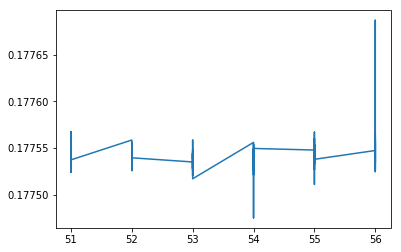

In [80]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [81]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


In [82]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120
Date,,,,,,,,,,,,,
2014-10-07 23:04:00,SPEX1 100ppb,2,1,51,0.029828,0.020197,0.010368,0.446003,0.235303,NaN,0.263441,0.142079,0.177535
2014-10-07 23:04:00,SPEX1 100ppb,2,2,51,0.029824,0.020195,0.010369,0.446005,0.235297,NaN,0.263436,0.142082,0.177541
2014-10-07 23:04:00,SPEX1 100ppb,2,3,51,0.029841,NaN,0.010368,0.446012,0.235289,NaN,0.263462,0.142085,0.177568
2014-10-07 23:04:00,SPEX1 100ppb,2,4,51,0.029828,0.020198,0.010368,NaN,0.235308,NaN,0.263448,0.142074,0.177529
2014-10-07 23:04:00,SPEX1 100ppb,2,5,51,0.029828,0.020194,0.010367,0.445987,0.235301,0.742935,0.263450,0.142088,0.177555
2014-10-07 23:04:00,SPEX1 100ppb,2,6,51,0.029838,NaN,0.010368,0.446016,0.235313,0.742935,0.263452,0.142071,0.177524
2014-10-07 23:04:00,SPEX1 100ppb,2,7,51,NaN,NaN,0.010368,NaN,0.235300,0.742935,0.263452,0.142076,0.177545
2014-10-07 23:04:00,SPEX1 100ppb,2,8,51,0.029831,0.020201,0.010369,0.446016,0.235302,NaN,0.263445,0.142087,0.177539
2014-10-07 23:04:00,SPEX1 100ppb,2,9,51,0.029832,0.020197,0.010369,0.446012,0.235295,0.742935,0.263436,0.142079,0.177541


In [83]:
df_outlier_raw[df_outlier_raw[column].notnull()][column]

Filenumber  Date               
52          2014-10-07 23:12:00    0.187123
            2014-10-07 23:12:00    0.187108
            2014-10-07 23:12:00    0.187169
54          2014-10-07 23:27:00    0.187061
56          2014-10-07 23:43:00    0.187298
Name: 124/120, dtype: float64

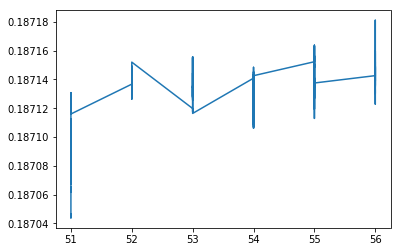

In [84]:
# Check sample measurements
df = df_outlier_rej_raw

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [85]:
df[df["Sample"] == sample][column].std()

2.435009628248441e-05

In [86]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

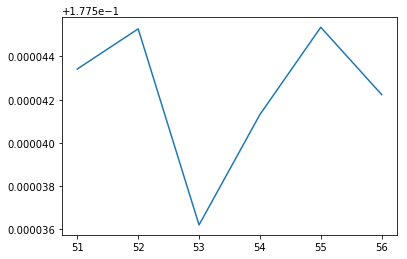

In [87]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [88]:
data_mean_int

,Filenumber,Sample,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120
Date,,,,,,,,,,,
2014-10-07 23:04:00,51,SPEX1 100ppb,0.029827,0.020195,0.010368,0.446005,0.235299,0.742935,0.263445,0.142080,0.177543
2014-10-07 23:12:00,52,SPEX1 100ppb,0.029832,0.020198,0.010368,0.446014,0.235301,0.742935,0.263444,0.142080,0.177545
2014-10-07 23:20:00,53,SPEX1 100ppb,0.029831,0.020196,0.010368,0.446018,0.235304,0.742935,0.263445,0.142074,0.177536
2014-10-07 23:27:00,54,SPEX1 100ppb,0.029832,0.020201,0.010368,0.446017,0.235302,0.742935,0.263447,0.142076,0.177541
2014-10-07 23:35:00,55,SPEX1 100ppb,0.029831,0.020200,0.010372,0.446016,0.235300,0.742935,0.263447,0.142077,0.177545
2014-10-07 23:43:00,56,SPEX1 100ppb,0.029833,0.020201,0.010368,0.446010,0.235304,0.742935,0.263442,0.142076,0.177542


In [89]:
date_list = []
                         
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [90]:
drop_sum = []

In [91]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

In [92]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [93]:
data_mean_int_sum

112/120                   114/120                   115/120  \
                  mean       SD2 count      mean       SD2 count      mean   
Sample                                                                       
SPEX1 100ppb  0.029831  0.000004     6  0.020198  0.000005     6  0.010369   

                               116/120  ...  118/120   119/120            \
                   SD2 count      mean  ...    count      mean       SD2   
Sample                                  ...                                
SPEX1 100ppb  0.000003     6  0.446013  ...        6  0.263445  0.000004   

                     122/120                   124/120                  
             count      mean       SD2 count      mean       SD2 count  
Sample                                                                  
SPEX1 100ppb     6  0.142077  0.000005     6  0.177542  0.000007     6  

[1 rows x 27 columns]

In [94]:
date_list = []

epsilon_int_SPEX = SSB(data_mean_int.drop(date_list), "SPEX1 100ppb", 10000)
delta_raw_SPEX = SSB(data_mean_raw.drop(date_list), "SPEX1 100ppb", 1000)

In [95]:
epsilon_int_SPEX

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2014-10-07 23:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SPEX1 100ppb
2014-10-07 23:12:00,0.0,0.988918,1.457386,-0.133563,0.064036,-0.058021,0.000000e+00,-0.037351,0.190412,0.307732,SPEX1 100ppb
2014-10-07 23:20:00,0.0,-0.258197,-1.836742,0.194034,0.050984,0.138473,-1.110223e-12,-0.026940,-0.262460,-0.399140,SPEX1 100ppb
2014-10-07 23:27:00,0.0,0.262834,1.522724,-1.785318,-0.001399,-0.019972,0.000000e+00,0.054142,0.017724,0.030015,SPEX1 100ppb
2014-10-07 23:35:00,0.0,-0.387057,-0.526753,3.363992,0.055935,-0.121192,0.000000e+00,0.081588,0.093473,0.201458,SPEX1 100ppb
2014-10-07 23:43:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SPEX1 100ppb


In [96]:

date_list = []

epsilon_int_SPEX = epsilon_int_SPEX.drop(date_list)
delta_raw_SPEX = delta_raw_SPEX.drop(date_list)

In [97]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -1000) & (df["Filenumber"] <= 1000)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [98]:
epsilon_int_SPEX = epsilon_process(epsilon_int_SPEX)
delta_raw_SPEX = epsilon_process(delta_raw_SPEX)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [99]:
epsilon_int_SPEX

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2014-10-07 23:12:00,52,0.988918,1.457386,-0.133563,0.064036,-0.058021,0.000000e+00,-0.037351,0.190412,0.307732,SPEX1 100ppb
2014-10-07 23:20:00,53,-0.258197,-1.836742,0.194034,0.050984,0.138473,-1.110223e-12,-0.026940,-0.262460,-0.399140,SPEX1 100ppb
2014-10-07 23:27:00,54,0.262834,1.522724,-1.785318,-0.001399,-0.019972,0.000000e+00,0.054142,0.017724,0.030015,SPEX1 100ppb
2014-10-07 23:35:00,55,-0.387057,-0.526753,3.363992,0.055935,-0.121192,0.000000e+00,0.081588,0.093473,0.201458,SPEX1 100ppb


In [100]:
epsilon_SPEX_sum = np.round(epsilon_int_SPEX.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_SPEX_sum = np.round(delta_raw_SPEX.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)

epsilon_sum_all = epsilon_SPEX_sum
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_SPEX_sum
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [101]:
epsilon_sum_all

112/120             114/120              115/120               \
                mean   SD2 count    mean    SD2 count    mean    SD2 count   
Sample                                                                       
SPEX1 100ppb   0.152  1.25     4   0.154  3.266     4    0.41  4.303     4   

             116/120  ...  118/120 119/120              122/120              \
                mean  ...    count    mean    SD2 count    mean   SD2 count   
Sample                ...                                                     
SPEX1 100ppb   0.042  ...        4   0.018  0.118     4    0.01  0.39     4   

             124/120               
                mean    SD2 count  
Sample                             
SPEX1 100ppb   0.035  0.622     4  

[1 rows x 27 columns]

In [531]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_SPEX, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_SPEX, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

NameError: name 'hdf5_sum_file' is not defined

In [532]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

NameError: name 'hdf5_sum_file' is not defined

# Raw data to xls file

In [44]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [45]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
#background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [102]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_new.xlsx', engine='xlsxwriter')


In [103]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_SPEX.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_SPEX.to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [104]:
writer_orig.save()

In [111]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

NameError: name 'hdf5_sum_file' is not defined

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [105]:
hdf5_file.flush()
hdf5_file.close()

In [ ]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')